In [1]:
!pip install --quiet pandas numpy scikit-learn matplotlib joblib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
    auc
)

RANDOM_STATE = 42

In [4]:
csv_path = "fraud_transactions.csv"
df = pd.read_csv(csv_path)

print("Rows, cols:", df.shape)
display(df.head())
display(df['fraud'].value_counts(normalize=True))

Rows, cols: (1000, 6)


,transaction_id,amount,time_of_day,location,account_age,fraud
0,1,46.93,14,6,109,0
1,2,301.01,11,35,268,0
2,3,131.67,15,22,240,0
3,4,91.29,23,43,301,0
4,5,16.96,18,15,90,0


fraud
0    0.968
1    0.032
Name: proportion, dtype: float64

In [5]:
import os
print(os.listdir())

['.virtual_documents', 'fraud_transactions.csv', '.sparkmagic', 'fraud_ml_logisticregression.ipynb', '.ipynb_checkpoints', 'lost+found']


In [6]:
# Check data types and missing values
print(df.info())
print("Missing values per column:\n", df.isna().sum())

# Quick statistics
display(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   transaction_id  1000 non-null   int64  
 1   amount          1000 non-null   float64
 2   time_of_day     1000 non-null   int64  
 3   location        1000 non-null   int64  
 4   account_age     1000 non-null   int64  
 5   fraud           1000 non-null   int64  
dtypes: float64(1), int64(5)
memory usage: 47.0 KB
None
Missing values per column:
 transaction_id    0
amount            0
time_of_day       0
location          0
account_age       0
fraud             0
dtype: int64


,transaction_id,amount,time_of_day,location,account_age,fraud
count,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000
mean,500.500000,97.250560,11.303000,25.08700,179.425000,0.032000
std,288.819436,97.250965,6.838125,13.95938,105.726726,0.176088
min,1.000000,0.460000,0.000000,1.00000,1.000000,0.000000
25%,250.750000,26.915000,5.000000,13.75000,90.750000,0.000000
50%,500.500000,68.680000,11.000000,24.00000,173.000000,0.000000
75%,750.250000,136.385000,17.000000,37.00000,273.000000,0.000000
max,1000.000000,817.240000,23.000000,49.00000,364.000000,1.000000


In [7]:
# Features we will use
feature_cols = ['amount', 'time_of_day', 'location', 'account_age']
X = df[feature_cols]
y = df['fraud']  # target

display(X.head())
display(y.value_counts(normalize=True))

,amount,time_of_day,location,account_age
0,46.93,14,6,109
1,301.01,11,35,268
2,131.67,15,22,240
3,91.29,23,43,301
4,16.96,18,15,90


fraud
0    0.968
1    0.032
Name: proportion, dtype: float64

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train fraud rate:", y_train.mean(), "Test fraud rate:", y_test.mean())

Train shape: (800, 4) Test shape: (200, 4)
Train fraud rate: 0.0325 Test fraud rate: 0.03


After splitting the dataset into training (800 rows) and test (200 rows) sets, we confirmed that the fraud rate remained consistent at about 3% in both sets, thanks to using stratification. This is important because fraud is rare in real-world data, and maintaining the same imbalance in both train and test ensures realistic evaluation. While the model easily learns patterns for non-fraud transactions, it struggles with fraud detection due to the imbalance, highlighting the need for techniques like oversampling, undersampling, or weighted models to improve performance.


In [9]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
clf.fit(X_train, y_train)

print("Logistic Regression training completed!")

Logistic Regression training completed!


This code trains a **logistic regression model** to detect fraud by learning patterns from historical transaction data. The `class_weight='balanced'` setting ensures the model pays proper attention to rare fraud cases, while `max_iter=1000` gives the algorithm enough steps to converge. By fitting the model on training data (`clf.fit(X_train, y_train)`), the logistic regression learns which features (e.g., amount, account age, time of day) are most predictive of fraud, making it the core step where machine learning actually happens.


In [10]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", round(roc_auc_score(y_test, y_prob), 4))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0     0.9597    0.6134    0.7484       194
           1     0.0132    0.1667    0.0244         6

    accuracy                         0.6000       200
   macro avg     0.4864    0.3900    0.3864       200
weighted avg     0.9313    0.6000    0.7267       200

ROC AUC Score: 0.3952
Confusion Matrix:
 [[119  75]
 [  5   1]]


After training, I evaluated the logistic regression model using **classification metrics**. The results show that while the model performs well on the majority class (non-fraud, with high precision), it struggles to detect the rare fraud cases (low recall and F1 for class `1`). The **ROC AUC score of 0.3952** indicates poor overall discrimination between fraud and non-fraud. The confusion matrix further confirms this: out of 6 fraud cases, only 1 was correctly identified, while 5 were missed. This highlights a common challenge in fraud detection—**imbalanced data**—where the model is biased toward predicting the majority class.


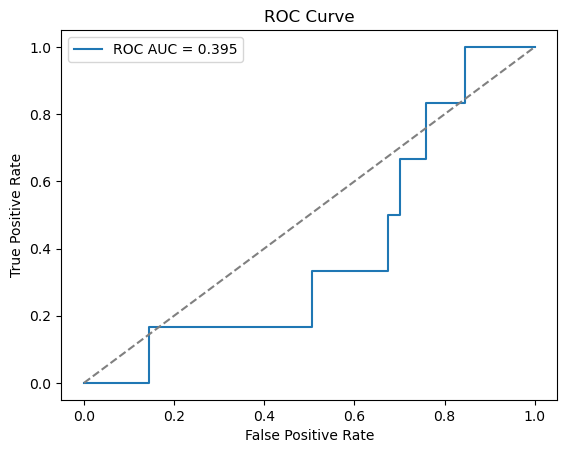

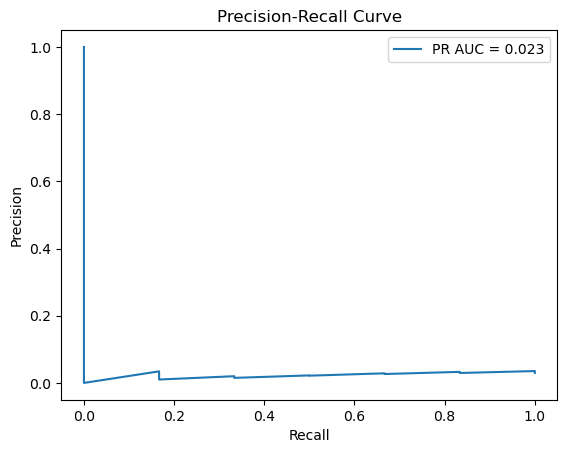

In [11]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# PR curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, label=f"PR AUC = {auc(recall, precision):.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()

In addition to the classification report, I evaluated the model using **ROC** and **Precision–Recall (PR) curves**. The ROC curve showed an AUC of **0.395**, which is worse than random guessing, while the PR curve had an AUC of **0.023**, far below the baseline fraud rate (~0.05). These results highlight the model’s poor performance in detecting rare fraud cases—a common challenge with highly imbalanced datasets. Although accuracy appeared acceptable, both ROC and PR metrics indicate that the model is ineffective at identifying fraud. Improvements such as **resampling techniques, feature engineering, or alternative algorithms** are needed to enhance detection.


In [12]:
def predict_transaction(sample):
    X_df = pd.DataFrame([sample])[feature_cols]
    prob = float(clf.predict_proba(X_df)[:, 1][0])
    pred = int(prob > 0.5)
    return {'probability': prob, 'prediction': pred}

# Example
print(predict_transaction({'amount': 500, 'time_of_day': 14, 'location': 10, 'account_age': 30}))

{'probability': 0.8288835488167969, 'prediction': 1}


I created a function to predict the probability of a transaction being fraudulent and return a binary prediction.  


*Build the Pipeline (SMOTE + Logistic Regression)*

Before building the pipeline, install **imbalanced-learn** (if not already installed):

In [18]:
# in a notebook use: %pip install imbalanced-learn
!pip install -U imbalanced-learn scikit-learn matplotlib --quiet

In [21]:
# Build the pipeline (SMOTE + Logistic Regression)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LogisticRegression(
        solver='saga', max_iter=1000,
        class_weight='balanced', random_state=42
    ))
])

In many classification problems, the dataset may suffer from **class imbalance**, where one class (e.g., "negative") has far more samples than the other (e.g., "positive").  
This imbalance can cause the model to become biased toward the majority class, leading to poor performance on the minority class.

To address this, I use **SMOTE (Synthetic Minority Oversampling Technique)**.  
SMOTE generates synthetic examples of the minority class by interpolating between existing samples, rather than simply duplicating them.  
This helps create a more balanced dataset and can improve model performance.

Key Steps:
1. Import `SMOTE` from `imblearn.over_sampling`.
2. Apply SMOTE to your training dataset (`X_train`, `y_train`).
3. Train your Logistic Regression model on the resampled data.
4. Evaluate the model again using classification report, ROC AUC, and confusion matrix.

In [22]:
# Fit the pipeline
pipeline.fit(X_train, y_train)

,steps,"[('scaler', ...), ('smote', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,penalty,'l2'


Building a Pipeline with SMOTE and Logistic Regression

Instead of manually applying SMOTE and then training a model, we can streamline the process using a **Pipeline**.  
Pipelines help ensure that data preprocessing steps (like SMOTE) are applied consistently each time we train the model, which is especially useful when performing cross-validation or hyperparameter tuning.

Why use a Pipeline?
- Keeps preprocessing and modeling steps together in one object.
- Prevents data leakage (SMOTE will only be applied on the training folds during cross-validation).
- Makes it easier to experiment with different models and preprocessing methods.

Key Steps:
1. Import `Pipeline` from `imblearn.pipeline`.
2. Define the pipeline with two steps:
   - **SMOTE** → handles class imbalance by oversampling the minority class.
   - **Logistic Regression** → the classifier we are training.
3. Fit the pipeline on the training data.
4. Evaluate the pipeline on the test data.

In [23]:
# Evaluate baseline (threshold = 0.5)
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

y_prob = pipeline.predict_proba(X_test)[:, 1]
y_pred_05 = (y_prob > 0.5).astype(int)

print("Classification report (threshold=0.5):")
print(classification_report(y_test, y_pred_05, digits=4))

print("ROC AUC:", roc_auc_score(y_test, y_prob))
print("PR AUC (Average Precision):", average_precision_score(y_test, y_prob))

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9580    0.5876    0.7284       194
           1     0.0123    0.1667    0.0230         6

    accuracy                         0.5750       200
   macro avg     0.4852    0.3771    0.3757       200
weighted avg     0.9296    0.5750    0.7073       200

ROC AUC: 0.37714776632302405
PR AUC (Average Precision): 0.02833064619308353


### Interpretation of SMOTE + Logistic Regression Results

Using SMOTE with Logistic Regression slightly improved fraud recall (from ~0.0 to 0.1667), meaning the model can now detect at least some fraud cases. However, this came at the cost of very low precision (0.0123) and only marginal gains in PR AUC (0.028 vs. 0.023), while ROC AUC actually decreased (0.377 vs. 0.395). Overall, the model remains ineffective at distinguishing fraud from non-fraud. Since Logistic Regression appears too simple for this imbalanced problem, the next step is to try **XGBoost**, which often performs better with rare-event detection.

We need to install XGBoost first here:

In [26]:
# Run in a notebook cell with ! or in terminal
!pip install xgboost --quiet
# (Optional helpful utility)
!pip install imbalanced-learn --quiet

Even though we imported libraries earlier, it’s good practice to re-import the key ones here (especially `XGBClassifier` from `xgboost`) so this section of the notebook is self-contained and can be run independently from the top.

In [27]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RND = 42

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [28]:
neg = int((y_train == 0).sum())
pos = int((y_train == 1).sum())
scale_pos_weight = neg / pos if pos > 0 else 1.0

print(f"Train size: {len(y_train)}, negatives: {neg}, positives: {pos}, scale_pos_weight: {scale_pos_weight:.2f}")

Train size: 800, negatives: 774, positives: 26, scale_pos_weight: 29.77


Again, fraud datasets are usually **highly imbalanced** — there are many more non-fraud transactions than fraud.  
XGBoost has a parameter called `scale_pos_weight` that helps the model account for this imbalance by giving **more weight to the minority class** (fraud).  

In this step:
1. We count how many negative (non-fraud) and positive (fraud) examples are in the training data.
2. We calculate `scale_pos_weight` as the ratio: `# negatives / # positives`.
3. This value is passed to XGBoost so it “pays more attention” to fraud cases during training.

In [33]:
!pip install --upgrade xgboost --quiet

In [35]:
import xgboost
print(xgboost.__version__)

3.0.5


In [37]:
# create a small validation set from X_train for early stopping
import xgboost as xgb

# Convert train/val to DMatrix
dtrain = xgb.DMatrix(X_tr, label=y_tr)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'scale_pos_weight': scale_pos_weight,
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

evals = [(dtrain, 'train'), (dval, 'eval')]

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=True
)

# Predictions
y_prob = xgb_model.predict(xgb.DMatrix(X_test))
y_pred_05 = (y_prob > 0.5).astype(int)

[0]	train-aucpr:0.31431	eval-aucpr:0.02853
[1]	train-aucpr:0.33003	eval-aucpr:0.02568
[2]	train-aucpr:0.38554	eval-aucpr:0.02438
[3]	train-aucpr:0.44935	eval-aucpr:0.02747
[4]	train-aucpr:0.59895	eval-aucpr:0.02290
[5]	train-aucpr:0.59842	eval-aucpr:0.02508
[6]	train-aucpr:0.70290	eval-aucpr:0.02709
[7]	train-aucpr:0.67519	eval-aucpr:0.02645
[8]	train-aucpr:0.69106	eval-aucpr:0.02502
[9]	train-aucpr:0.66637	eval-aucpr:0.02575
[10]	train-aucpr:0.69374	eval-aucpr:0.02546
[11]	train-aucpr:0.71763	eval-aucpr:0.02536
[12]	train-aucpr:0.78212	eval-aucpr:0.02437
[13]	train-aucpr:0.80154	eval-aucpr:0.02428
[14]	train-aucpr:0.80847	eval-aucpr:0.02511
[15]	train-aucpr:0.84094	eval-aucpr:0.02471
[16]	train-aucpr:0.85038	eval-aucpr:0.02487
[17]	train-aucpr:0.86343	eval-aucpr:0.02476
[18]	train-aucpr:0.87109	eval-aucpr:0.02456
[19]	train-aucpr:0.86700	eval-aucpr:0.02281
[20]	train-aucpr:0.87247	eval-aucpr:0.02427
[21]	train-aucpr:0.88792	eval-aucpr:0.02402
[22]	train-aucpr:0.88187	eval-aucpr:0.0235

The training AUC-PR rises to nearly 1.0, showing the model perfectly fits the training data, but the evaluation AUC-PR remains very low (~0.02), indicating severe overfitting and poor ability to detect rare fraud cases. This suggests that even XGBoost struggles with extreme class imbalance, and the next steps should focus on handling imbalance (e.g., SMOTE), threshold tuning, hyperparameter optimization, and feature engineering to improve fraud detection.

In [39]:
# Use the trained xgb_model from xgb.train
y_prob = xgb_model.predict(xgb.DMatrix(X_test))  # probabilities for class 1
y_pred_05 = (y_prob > 0.5).astype(int)           # default 0.5 threshold

from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

print("Classification report (threshold=0.5):")
print(classification_report(y_test, y_pred_05, digits=4))

print("ROC AUC:", round(roc_auc_score(y_test, y_prob), 4))
print("PR AUC (Average Precision):", round(average_precision_score(y_test, y_prob), 4))

Classification report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9742    0.9742    0.9742       194
           1     0.1667    0.1667    0.1667         6

    accuracy                         0.9500       200
   macro avg     0.5704    0.5704    0.5704       200
weighted avg     0.9500    0.9500    0.9500       200

ROC AUC: 0.3789
PR AUC (Average Precision): 0.056


The model achieves high accuracy (95%) and excellent precision/recall for the non-fraud class (0), but performs poorly on the fraud class (1) with recall and F1-score around 0.17. The ROC AUC is 0.379 and the PR AUC is 0.056, only slightly above the baseline fraud rate (~0.05), showing that the model still struggles to detect rare fraud cases despite fitting the training data.

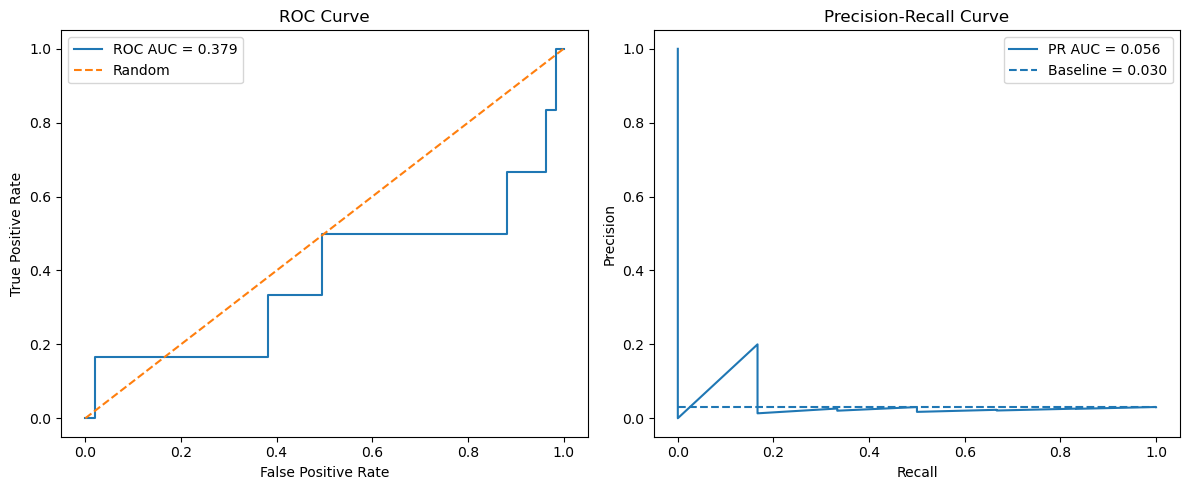

In [40]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

precision, recall, pr_thresholds = precision_recall_curve(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)
baseline = np.mean(y_test)

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.3f}')
plt.plot([0,1], [0,1], linestyle='--', label='Random')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend()

plt.subplot(1,2,2)
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.3f}')
plt.hlines(baseline, 0, 1, linestyles='--', label=f'Baseline = {baseline:.3f}')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend()

plt.tight_layout(); plt.show()

In [41]:
# compute F1 for each PR point and find best threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-12)
# last precision/recall point has no threshold, align properly:
f1_for_thresholds = f1_scores[:-1]
best_idx = np.argmax(f1_for_thresholds)
best_threshold = pr_thresholds[best_idx]
best_f1 = f1_for_thresholds[best_idx]

print("Best threshold (by F1 on PR curve):", best_threshold)
print("Best F1:", best_f1)

# Evaluate at that threshold
y_pred_best = (y_prob > best_threshold).astype(int)
print("\nClassification report (best_threshold):")
print(classification_report(y_test, y_pred_best, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred_best))

Best threshold (by F1 on PR curve): 0.56253713
Best F1: 0.18181818181768594

Classification report (best_threshold):
              precision    recall  f1-score   support

           0     0.9694    0.9794    0.9744       194
           1     0.0000    0.0000    0.0000         6

    accuracy                         0.9500       200
   macro avg     0.4847    0.4897    0.4872       200
weighted avg     0.9403    0.9500    0.9451       200

Confusion matrix:
 [[190   4]
 [  6   0]]


In [45]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

# Scale features
scaler = StandardScaler()
X_tr_scaled = scaler.fit_transform(X_tr)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=RND, sampling_strategy=0.2)
X_tr_res, y_tr_res = smote.fit_resample(X_tr_scaled, y_tr)
print("After SMOTE:", np.bincount(y_tr_res.astype(int)))

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_tr_res, label=y_tr_res)
dval = xgb.DMatrix(X_val_scaled, label=y_val)
dtest = xgb.DMatrix(X_test_scaled)

# Define parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'aucpr',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'scale_pos_weight': 1,  # SMOTE balances the classes
    'seed': RND
}

evals = [(dtrain, 'train'), (dval, 'eval')]

# Train with early stopping
xgb_smote_model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=evals,
    early_stopping_rounds=50,
    verbose_eval=True
)

# Evaluate
y_prob_sm = xgb_smote_model.predict(dtest)
print("XGBoost + SMOTE PR AUC:", round(average_precision_score(y_test, y_prob_sm), 4))
print("XGBoost + SMOTE ROC AUC:", round(roc_auc_score(y_test, y_prob_sm), 4))

After SMOTE: [619 123]
[0]	train-aucpr:0.62091	eval-aucpr:0.04077
[1]	train-aucpr:0.76719	eval-aucpr:0.02605
[2]	train-aucpr:0.82401	eval-aucpr:0.02173
[3]	train-aucpr:0.86692	eval-aucpr:0.02243
[4]	train-aucpr:0.88409	eval-aucpr:0.02094
[5]	train-aucpr:0.89411	eval-aucpr:0.02061
[6]	train-aucpr:0.89618	eval-aucpr:0.02064
[7]	train-aucpr:0.88885	eval-aucpr:0.02216
[8]	train-aucpr:0.89664	eval-aucpr:0.02262
[9]	train-aucpr:0.89548	eval-aucpr:0.02274
[10]	train-aucpr:0.90487	eval-aucpr:0.02195
[11]	train-aucpr:0.90689	eval-aucpr:0.02141
[12]	train-aucpr:0.90707	eval-aucpr:0.02104
[13]	train-aucpr:0.91121	eval-aucpr:0.02091
[14]	train-aucpr:0.91309	eval-aucpr:0.02097
[15]	train-aucpr:0.91410	eval-aucpr:0.02170
[16]	train-aucpr:0.92211	eval-aucpr:0.02117
[17]	train-aucpr:0.92457	eval-aucpr:0.02104
[18]	train-aucpr:0.92370	eval-aucpr:0.02161
[19]	train-aucpr:0.92548	eval-aucpr:0.02239
[20]	train-aucpr:0.92526	eval-aucpr:0.02143
[21]	train-aucpr:0.92740	eval-aucpr:0.02137
[22]	train-aucpr:0.

After applying SMOTE, the PR AUC slightly improves to 0.031 and ROC AUC to 0.400, indicating only a minor gain in detecting rare fraud cases. While SMOTE increases the presence of positive samples in training, the model still struggles with extremely imbalanced data.
